In [1]:
#!pip install obspy 

In [88]:
#Packages used
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.detrend import polynomial
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [3]:
from IPython.display import Latex

# Critical Scale Invariance

From statistical mechanics we know that when a system is near to its critical point we can see long-range correlations, a non Gaussian behaviour and multifractality. These fluctuations are generally connected to the scale invariant and universal behaviour of the scaling function. In this project we have used the methods in the given article which is trying to show that the healthy heart rate dynamics show a near critical point like behaviour from a robust scale invariance in the integrated incerement PDF.

# Data selection

The data consists of the RR intervals of 11 individuals who didn’t have any clinical symptoms. RR interval is defined as the interval between each successive R peak. The R peak is defined from the heart beat graph shown here. We gathered the data of 11 individuals and collected them together by resizing them depending on the data with the minimum length. In this way we tried to assume that we are analyzing the same interval for each individual.
 

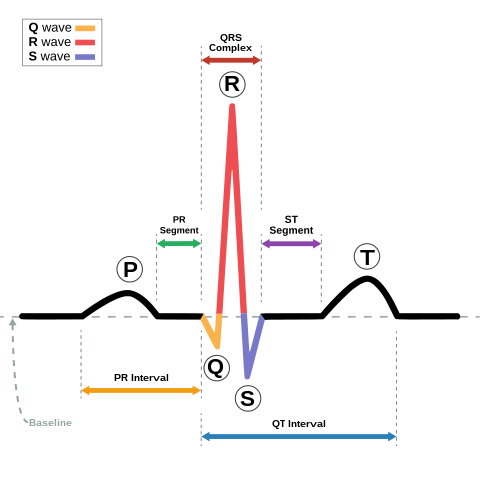

In [4]:
from IPython.display import Image
Image("rr_interval_image.png")

In [97]:
#list the files
filelist = os.listdir("rr_data_file")
if '.DS_Store' in filelist:
    filelist.remove('.DS_Store')
#read them into pandas
df_list = [pd.read_csv(f'rr_data_file/{file}',delimiter = "\t",names=[f'{file}']) for file in filelist]
min_len = min(map(len, df_list))
small_df = pd.concat(df_list,axis=1)
big_df = (small_df.T).apply(pd.to_numeric, errors='coerce')
cropped_df = big_df.iloc[:,:min_len]
batch1 = cropped_df.iloc[:,:int(cropped_df.shape[1]/2)]
batch2 = cropped_df.iloc[:,int(cropped_df.shape[1]/2):]

Because of the length of the data we decided two divide the data into 2 batches. And also we did a cleaning for the outliers according to our preference which gave us in total 4 batches.

In [100]:
#Reject the outliers
def reject_outliers(data):
    cleaned_rows = np.zeros((data.shape[0],data.shape[1]))
    N = data.shape[0]
    for i in range(N):
        
        row_data = data.iloc[i, :]

        row_mean = np.mean(row_data)
        row_std = np.std(row_data)
    
        threshold = 3
        lower_bound = row_mean - threshold * row_std
        upper_bound = row_mean + threshold * row_std
    
        outliers = np.logical_or(row_data < lower_bound, row_data > upper_bound)
    
        cleaned_row = np.where(outliers, np.nan, row_data)
        
        cleaned_rows[i,:] = np.array(cleaned_row)
        
    cleaned_data = np.array(cleaned_rows)
    return cleaned_data
batch1_cld = pd.DataFrame(reject_outliers(batch1))
batch2_cld = pd.DataFrame(reject_outliers(batch2))

Plots of of first patient as beat vs interbeat intervalues 

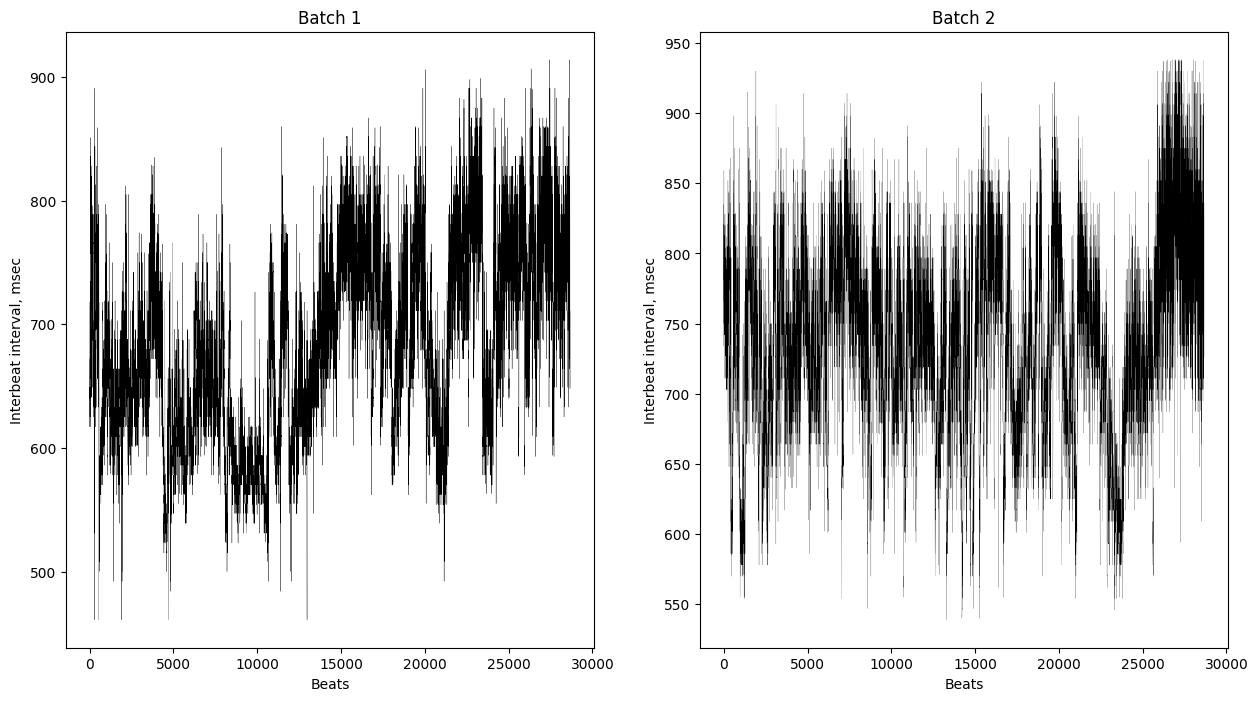

In [101]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(reject_outliers(batch1)[0,:], color = 'black', linewidth=0.2)
axs[0].set_title('Batch 1')
axs[0].set_xlabel('Beats')
axs[0].set_ylabel('Interbeat interval, msec')

axs[1].plot(reject_outliers(batch2)[0,:], color = 'black', linewidth=0.1)
axs[1].set_title('Batch 2')
axs[1].set_xlabel('Beats')
axs[1].set_ylabel('Interbeat interval, msec')
plt.show()

# Process

$$B(m)= \sum_{j=1}^{m}b(j) $$

In [102]:
#integrating
df_cum1 = batch1.cumsum(axis = 1, skipna = True)
df_cum2 = batch2.cumsum(axis = 1, skipna = True)
df_cum1_cld = batch1_cld.cumsum(axis = 1, skipna = True)
df_cum2_cld = batch2_cld.cumsum(axis = 1, skipna = True)

Then resultant B(m) is divided into sliding segments of size 2s. Then in each segment the best qth order polynomial is fit to the data. The differences are obtained by sliding in time over the segments, where the given equation is the deviation from the polynomial fit.

$$\Delta_{s}B(i) = B^{*}(i+s)-B^{*}(i) $$

By this procedure, the q-1th order polynomial trends are eliminated. By changing s we are applying a coarse graining. Smaller s means a more fine grained dataset.

# Remove non-stationarity of the data by local detrending and differencing

In [103]:
def detrend(df, s_vals, p_order):
  '''
  Input:
  df : DataFrame containing interbeat times (RR intervals) in ms for different people in each row
  s_vals : defines the size of the segment over which the detrending and temporal correlation is done
  p_order : polynomial degree for detrending
  Output: 
  List of numpy-Arrays containing the detrended increments of all analyzed people for various values of s
  '''
  Delta_S=[] #stores the detrended data of all patients for every s 
  for idx, s in enumerate(s_vals): #iterate over different values of s
    Delta_S_B=[]
    for j in range(df.shape[0]): #iterate over the number of patients
      row = df.iloc[j,:]
      intval = int(np.floor(df.shape[1]/(2*s))) # maximum numbers of 2*s intervals in the data series
      for i in range(intval):
        polynomial(row[i*2*s:(i+1)*2*s],p_order, plot =False)    # polynomial detrending, modifies data inplace
      polynomial(row[intval*2*s:],p_order, plot =False)
      Delta_S_B_p=np.array([row[i+s]-row[i] for i in range(intval*2*s) if i+s< df.shape[1]])
      Delta_S_B.append(Delta_S_B_p/np.std(Delta_S_B_p))  # append the normalized data divided by its std deviation
    Delta_S.append(np.array(Delta_S_B).flatten())

  return Delta_S

We decided the polynomial degree as 3 using the article.

In [113]:
# Define values of s and perform detrending on datasets
s_vals = [2**i for i in range(3,13)]
q = 3 #polynomial degree
#Delta_S1 = detrend(df_cum1,s_vals, q)
Delta_S1 = detrend(df_cum1_cld,s_vals, q)

In [105]:
def gauss(x, A, mu, sigma):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2 / (2*sigma**2)) 

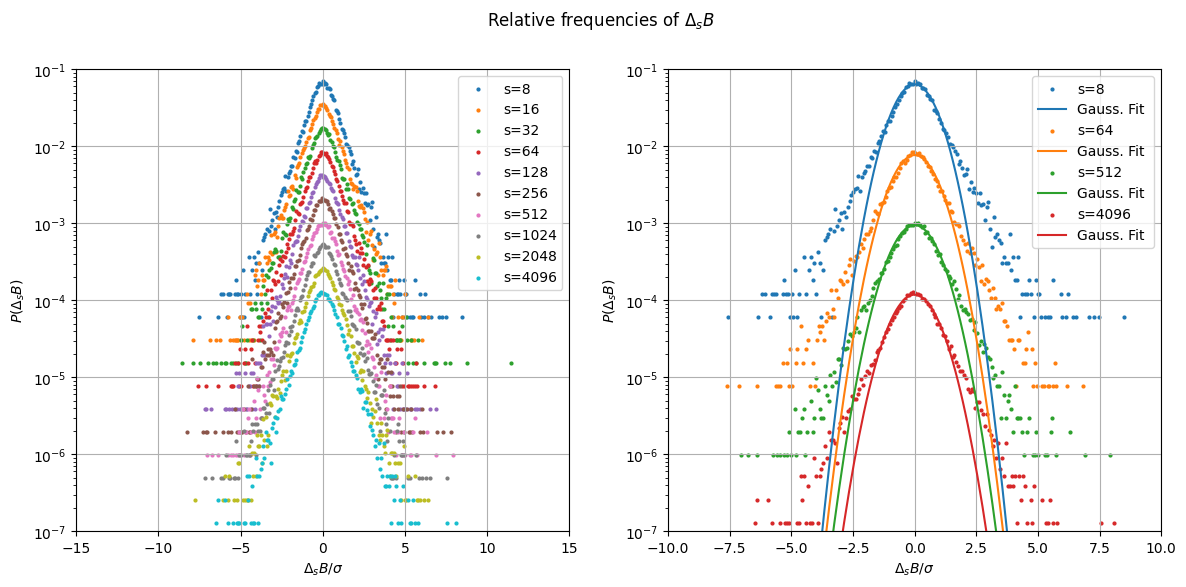

In [127]:
# Fitting the Gaussian and plotting the PDF of the integrated detrended increments
x = np.linspace(-20, 20, 400)
p0_gauss = [1,0,5]

def gauss_fit(values,n):
    histogram, bins = np.histogram(values, bins=int(np.sqrt(n)), range=(-20,20),density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    popt, pcov = curve_fit(gauss , bin_centers, histogram, p0=p0_gauss)
    return popt, pcov, histogram, bins, bin_centers


def plot_pdf_gaus(Delta_S):
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    for idx, s in enumerate(s_vals):
        n=len(Delta_S[idx])
        popt, pcov, histogram, bins, bin_centers = gauss_fit(Delta_S1[idx],n)
        ax[0].scatter(bin_centers, histogram/(s), label=f's={s}', s=4, marker='o')
        if idx%3==0:
            ax[1].scatter(bin_centers, histogram/(s), label=f's={s}', s=4, marker='o')
            ax[1].plot(x, gauss(x, *popt)/s, label='Gauss. Fit ')
    plt.suptitle('Relative frequencies of $\Delta_sB$')
    ax[0].set_yscale('log')
    ax[0].set_xlim((-15,15))
    ax[0].set_xlabel('$\Delta_sB/\sigma$')
    ax[0].set_ylabel('$P(\Delta_sB)$')
    ax[0].set_ylim(1e-7, 10**(-1))
    ax[0].legend()
    ax[0].grid(True)

    ax[1].set_yscale('log')
    ax[1].set_xlim((-10,10))
    ax[1].set_xlabel('$\Delta_sB/\sigma$')
    ax[1].set_ylabel('$P(\Delta_sB)$')
    ax[1].set_ylim(1e-7, 10**(-1))
    ax[1].legend()
    plt.grid(True)
    plt.show()
    
plot_pdf_gaus(Delta_S1)

Now we are going to do the fitting for a non gaussian function. Which is going to be the Castaign's equation:

$$ P(x) = \frac{1}{2\pi \lambda} \int  \frac{1}{\sigma^{2}} \exp(\frac{-\ln^2(\sigma/\sigma_0)}{2\lambda^2}) \exp(-\frac{x^2}{\sigma^2})d\sigma$$

In [116]:
def castaing(x, lambda_, sigma_0):

    def kernel(sigma, lambda_, x, sigma_0):
        return 1/(2*np.pi*lambda_*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma / sigma_0)**2/lambda_**2) / 2)
    result = quad(kernel, 0, np.inf, args=(lambda_, x, sigma_0))
    
    return result[0]

Castaing = np.vectorize(castaing)

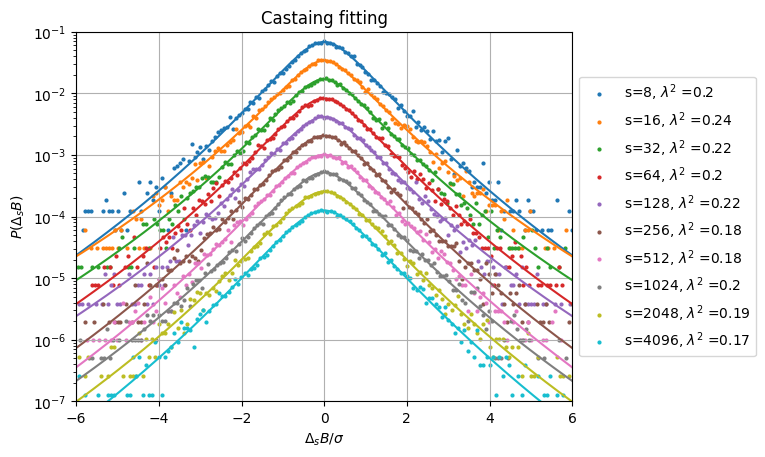

In [123]:
p0_cast = [np.sqrt(0.16),1]

def castaing_fit(values,n):
    histogram, bins = np.histogram(values, bins=int(np.sqrt(n)), range=(-20,20),density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    popt, pcov = curve_fit(Castaing, bin_centers, histogram, p0=p0_cast)
    return popt, pcov, histogram, bins, bin_centers

def plot_pdf_castaign(Delta_S):
    lambda_lst = []
    lambda_err_lst = []
    for idx, s in enumerate(s_vals):
        n=len(Delta_S[idx])
        popt, pcov, histogram, bins, bin_centers = castaing_fit(Delta_S[idx],n)
        lambda_err_lst.append(np.sqrt(pcov[0,0]))
        lambda_lst.append(popt[0]**2)
        plt.scatter(bin_centers, histogram/s, label=f's={s}, $\lambda^2$ ={round(lambda_lst[idx],2)}', s=4, marker='o')
        plt.plot(x, Castaing(x, *popt)/s)

    plt.yscale('log')
    plt.xlim((-6,6))
    plt.xlabel('$\Delta_sB/\sigma$')
    plt.ylabel('$P(\Delta_sB)$')
    plt.ylim(1e-7, 1e-1)
    plt.title("Castaing fitting")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    return np.array(lambda_err_lst), np.array(lambda_lst)

lambda_err_lst, lambda_lst = plot_pdf_castaign(Delta_S1)

# Collapse Plot

We can try to see the fit for every value of s by doing a collapsed plot. We fit the gaussiand and also the Castaing's equation for the whole dataset.

Chi squared Castaing 0.0001693247006737055
Chi squared Gauss 0.0026203593204638673


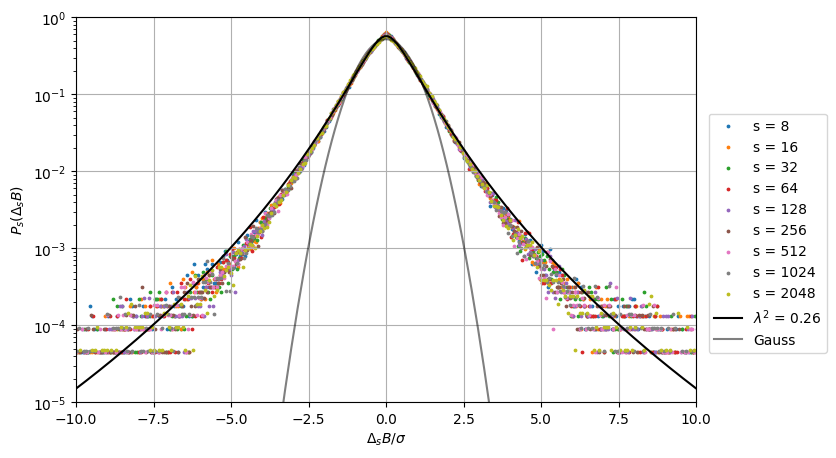

In [130]:
fig=plt.figure(figsize=(8,5))

def complete_scatter(Delta_S):
    for i,DBs in enumerate(Delta_S):
    
        counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-20, 20),density=True)
        bin_cen=(edges[1:]+edges[:-1])/2
        plt.scatter(bin_cen, counts, s=3, label=f's = {s_vals[i]}' )

    complete_dataset=np.concatenate(Delta_S)
    return complete_dataset

def chi_sqrd(counts,fit_res,bin_cen):
    chi_2 = np.sum((counts[counts!=0]-fit_res)**2/(counts[counts!=0]))/(counts[counts!=0].shape[0]-2)
    return chi_2
    
# Fitting curves to data
def gaus_nongaus_fit(complete_dataset):
    popt_c, pcov_c, counts_all, edges_all, bin_centers = castaing_fit(complete_dataset,complete_dataset.size)
    popt_g, pcov_g, counts_all, edges_all, bin_centers = gauss_fit(complete_dataset,complete_dataset.size)
    bin_cen_all=(edges_all[1:]+edges_all[:-1])/2
    plt.plot(x, Castaing(x, *popt_c), label=r'$\lambda^2$ = {:.2f}'.format(*popt_c**2), color='black')
    plt.plot(x, gauss(x, *popt_g), label='Gauss', color='black', alpha=0.5)

    # Compute chisquared
    chi_2_c = chi_sqrd(counts_all,Castaing(bin_cen_all[counts_all!=0], *popt_c),bin_cen_all)
    chi_2_g = chi_sqrd(counts_all,gauss(bin_cen_all[counts_all!=0], *popt_g),bin_cen_all)
    
    print('Chi squared Castaing', chi_2_c)
    print('Chi squared Gauss', chi_2_g)

    plt.yscale('log')
    plt.xlim(-10,10),
    plt.ylim(1e-5, 1e0)
    plt.xlabel(r'$\Delta_s B/\sigma$')
    plt.ylabel(r'$P_s(\Delta_s B)$')
    lgnd = plt.legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.show()

complete_dataset = complete_scatter(Delta_S)
gaus_nongaus_fit(complete_dataset)

We can see that the integrated increments of the interbeat intervals are showing a non Gaussian behaviour. We see scale invariant behaviour which we would expect to see near critical point like states.

# $\lambda^2$ dependence on s parameter

[0.00358048 0.00381237 0.0038687  0.00366966 0.00365552 0.00324789
 0.00323379 0.00384865 0.00324739 0.00291355]


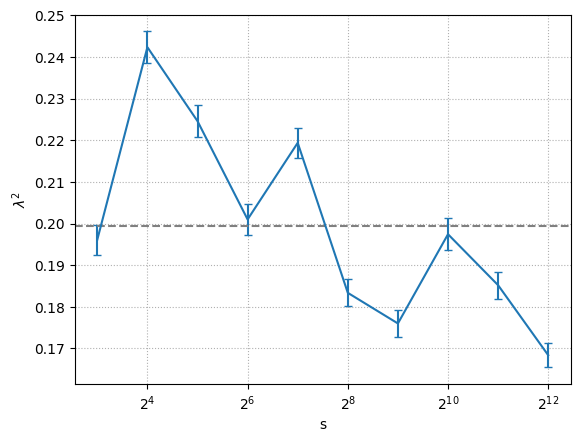

In [133]:
mean_lambdas = np.mean(lambda_lst)

lambda_err_lst=2*lambda_err_lst*np.sqrt(lambda_lst)

plt.errorbar(s_vals, lambda_lst, yerr = lambda_err_lst, capsize =3)
print(lambda_err_lst)
plt.axhline(y=mean_lambdas, linestyle='dashed', color='grey', label = fr'$<\lambda^2$>={mean_lambdas:.2f}' )
plt.grid(linestyle='dotted')
plt.xscale('log',base=2, subs=[])
plt.xlabel('s')
plt.ylabel('$\lambda^2$')
plt.show()

# Conclusion

Here we are not seeing a remarkable decrease in lambda squared which proves the scale invariance using Castaing's equation.

# Scale variance of the interbeat increment

In [ ]:
# A different detrending method from Ching 2007
def detrend_inc(df, s_vals, p_order):
  Delta_S=[] #stores the detrended data of all patients for every s 
  for idx, s in enumerate(s_vals): #iterate over different values of s
    Delta_S_B=[]
    for j in range(df.shape[0]): #iterate over the number of patients
      row = df.iloc[j,:]
      intval = int(np.floor(df.shape[1]/(2*s))) # maximum numbers of 2*s intervals in the data series
      for i in range(intval):
        polynomial(row[i*2*s:(i+1)*2*s],p_order, plot =False)    # polynomial detrending, modifies data inplace
      polynomial(row[intval*2*s:],p_order, plot =False)
      Delta_S_B_p=np.array([row[j+i+1]-row[j+i] for i in range(2*s-1) for j in range(intval)]) #undoing the integration
      Delta_S_B_n=np.array([Delta_S_B_p[i+s]-Delta_S_B_p[i] for i in range(len(Delta_S_B_p)) if i+s< len(Delta_S_B_p)])
      Delta_S_B.append(Delta_S_B_n/np.std(Delta_S_B_n))  # append the normalized data divided by its std deviation
    Delta_S.append(np.array(Delta_S_B).flatten())

  return Delta_S
# Less as values to degrees the time
s_vals = [2**i for i in range(3,13)]
Delta_S = detrend_inc(df_cum1_cld,s_vals, q)

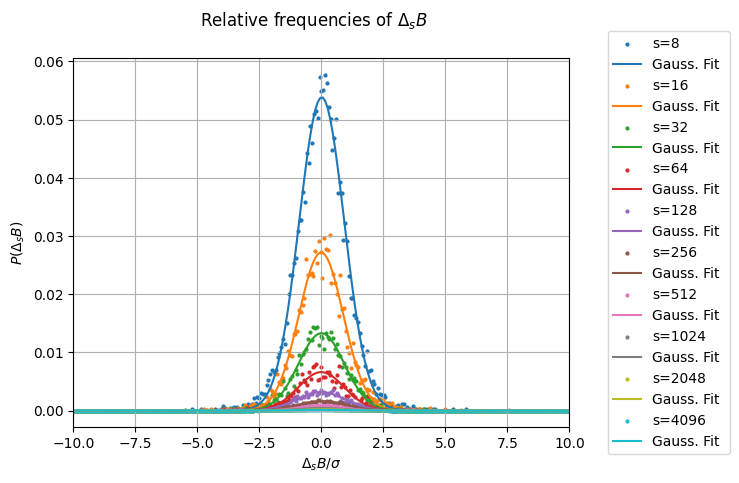

In [144]:
x = np.linspace(-20, 20, 400)

for idx, s in enumerate(s_vals):
    n=len(Delta_S[idx])
    histogram, bins = np.histogram(Delta_S[idx], bins=int(np.sqrt(n)), range=(-20,20), density =True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.scatter(bin_centers, histogram/(s), label=f's={s}', s=4, marker='o')
    plt.xlim(-10,10)
    popt, pcov = curve_fit(gauss , bin_centers, histogram, p0=[0.1,0,2])
    plt.plot(x, gauss(x, *popt)/s, label=f'Gauss. Fit ')

plt.suptitle('Relative frequencies of $\Delta_sB$')
plt.xlabel('$\Delta_sB/\sigma$')
plt.ylabel('$P(\Delta_sB)$')
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', borderaxespad=0)
plt.grid(True)

# References
1) By Created by Agateller (Anthony Atkielski), converted to svg by atom. - SinusRhythmLabels.png, Public Domain, https://commons.wikimedia.org/w/index.php?curid=1560893
2) Irurzun, I. M., Garavaglia, L., Defeo, M. M., & Thomas Mailland, J. (2021). RR interval time series from healthy subjects (version 1.0.0). PhysioNet. https://doi.org/10.13026/51yd-d219
3)Leopoldo Garavaglia, Damián Gulich, Magdalena M Defeo, Julieta Thomas Mailland, Isabel M. Irurzun, The Effect of Age on the Heart Rate Variability of Healthy Subjects, Plos One.
4) Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.
5) Ivanov PC, Amaral LA, Goldberger AL, Havlin S, Rosenblum MG, Struzik ZR, Stanley HE. Multifractality in human heartbeat dynamics. Nature. 1999 Jun 3;399(6735):461-5. doi: 10.1038/20924. PMID: 10365957.
6) Kiyono K, Struzik ZR, Aoyagi N, Yamamoto Y. Multiscale probability density function analysis: non-Gaussian and scale-invariant fluctuations of healthy human heart rate. IEEE Trans Biomed Eng. 2006 Jan;53(1):95-102. doi: 10.1109/TBME.2005.859804. PMID: 16402608.
7) Ching, Emily S. C. and Tsang, Yue-Kin (2007) Multifractality and scale invariance in human heartbeat dynamics. American Physical Society doi: 10.1103/PhysRevE.76.041910
